In [12]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp

import cv2
import os
import random
import matplotlib.pyplot as plt

## Data Class

In [11]:
class CellSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # (H, W)

        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Normalize
        image = image.astype('float32') / 255.0
        mask = (mask > 0).astype('float32')  # Binary mask

        # Convert to CHW format for PyTorch
        image = torch.tensor(image).unsqueeze(0)  # (1, H, W)
        mask = torch.tensor(mask).unsqueeze(0)    # (1, H, W)
        
        # Pad so that divisible by 32
        image = pad_to_multiple(image)
        mask = pad_to_multiple(mask)
        
        return image, mask

In [10]:
def pad_to_multiple(x, multiple=32):
    h, w = x.shape[-2], x.shape[-1]
    pad_h = (multiple - h % multiple) % multiple
    pad_w = (multiple - w % multiple) % multiple
    return F.pad(x, (0, pad_w, 0, pad_h)) 

In [43]:
def unpad_to_shape(x, original_h, original_w):
    return x[..., :original_h, :original_w]

## Load Data

In [13]:
train_ds = CellSegmentationDataset("data/images_train", "data/masks_train")
val_ds =  CellSegmentationDataset("data/images_val", "data/masks_val")
test_ds = CellSegmentationDataset("data/images_test", "data/masks_test")

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=4)
test_loader = DataLoader(test_ds, batch_size=1)

## This is done cause of compute issues

In [18]:
from torch.utils.data import Subset

# Randomly pick 10 indices from the training dataset
subset_indices = random.sample(range(len(train_ds)), 10)

# Create a subset dataset
train_subset = Subset(train_ds, subset_indices)

In [19]:
train_loader = DataLoader(train_subset, batch_size=2, shuffle=True)

In [26]:
subset_indices = random.sample(range(len(test_ds)), 10)
test_subset = Subset(test_ds, subset_indices)
test_loader =  DataLoader(test_subset, batch_size=1)

## UNet Model Definition

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1,
    activation="sigmoid"
).to(device)

## Training

In [20]:
loss_fn = smp.losses.DiceLoss(mode='binary')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [21]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        preds = model(imgs)
        loss = loss_fn(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"[Epoch {epoch+1}] Training Loss: {total_loss / len(train_loader):.4f}")

[Epoch 1] Training Loss: 0.5212
[Epoch 2] Training Loss: 0.5155
[Epoch 3] Training Loss: 0.5116
[Epoch 4] Training Loss: 0.5102
[Epoch 5] Training Loss: 0.5063
[Epoch 6] Training Loss: 0.5041
[Epoch 7] Training Loss: 0.5180
[Epoch 8] Training Loss: 0.5063
[Epoch 9] Training Loss: 0.5044
[Epoch 10] Training Loss: 0.5085


## Evaluation/Testing

In [27]:
model.eval()
test_dice = 0.0
with torch.no_grad():
    for img, mask in test_loader:
        img, mask = img.to(device), mask.to(device)
        pred = model(img)
        pred_bin = (pred > 0.5).float()

        intersection = (pred_bin * mask).sum()
        union = pred_bin.sum() + mask.sum()
        dice = (2 * intersection) / (union + 1e-8)
        test_dice += dice.item()

print(f"Test Dice Score: {test_dice / len(test_loader):.4f}")

Test Dice Score: 0.8796


## Visualization of test predictions

In [48]:
def show_prediction(img, mask):
    model.eval()
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))
        pred_bin = (pred > 0.5).float().squeeze().cpu().numpy()
    pred_unpadded = unpad_to_shape(pred_bin, 520, 704)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(unpad_to_shape(img.squeeze(0), 520, 704), cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(unpad_to_shape(mask.squeeze(0), 520, 704), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred_unpadded, cmap='gray')
    plt.show()

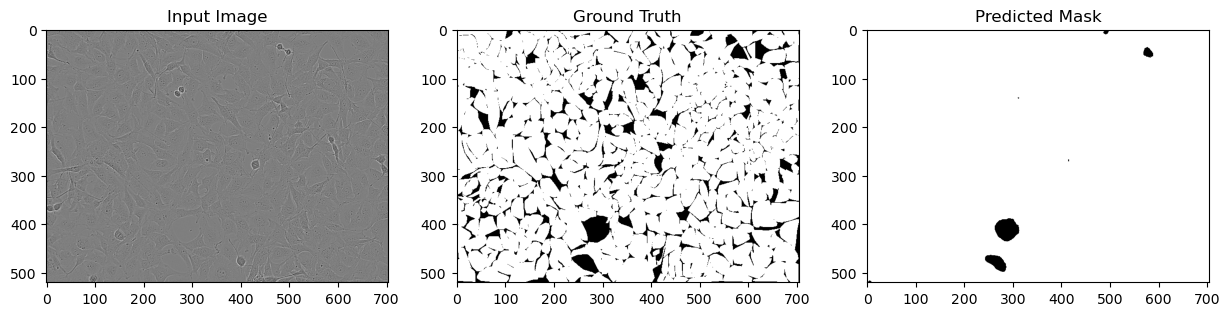

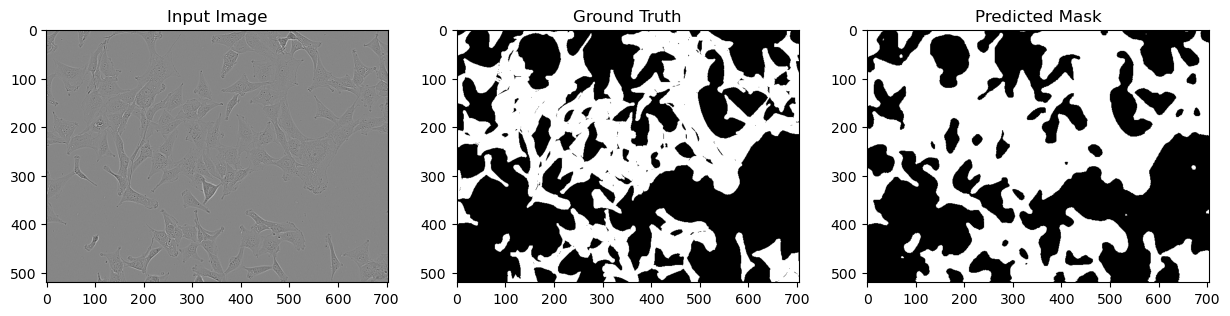

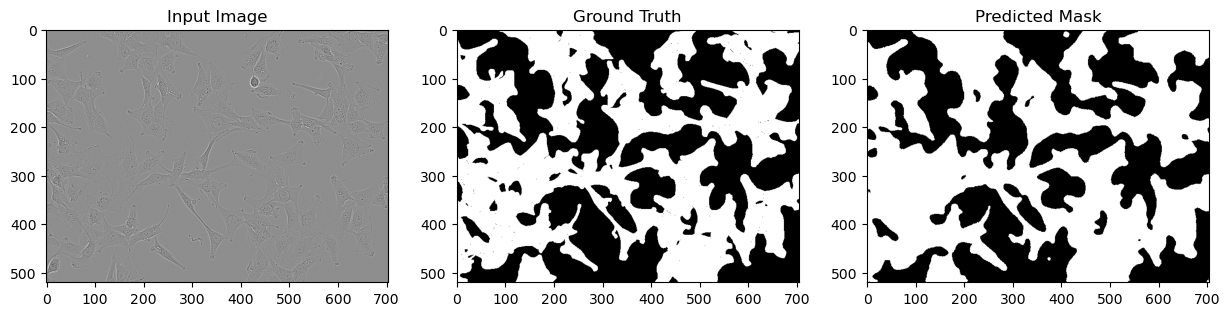

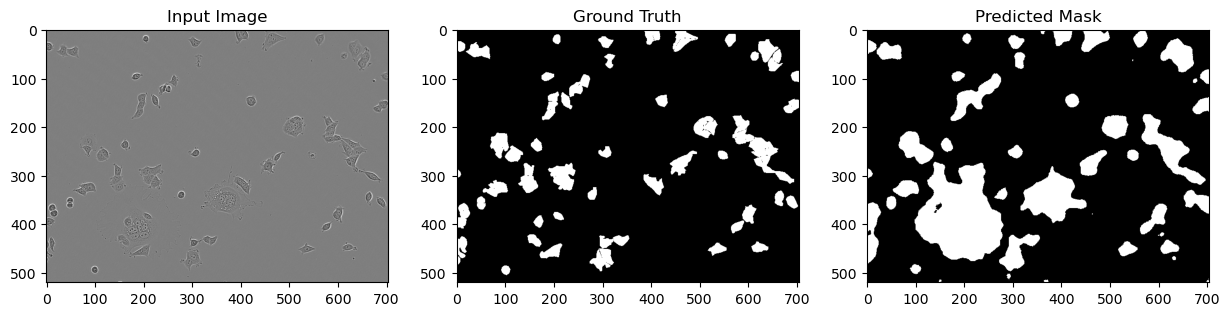

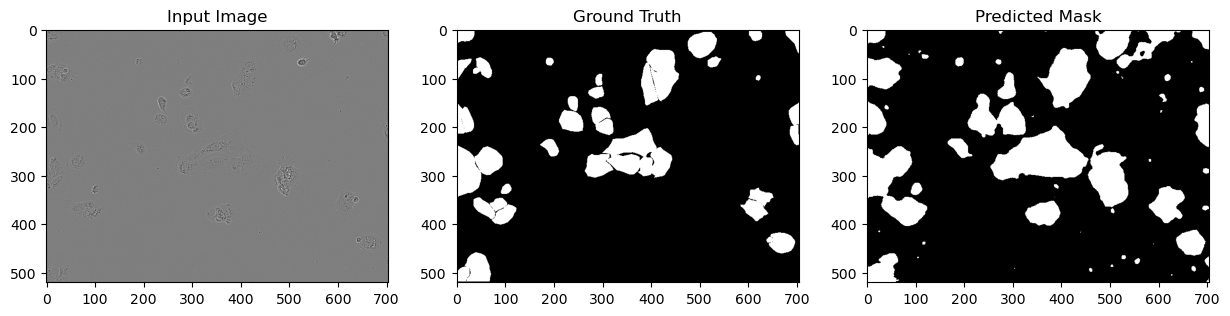

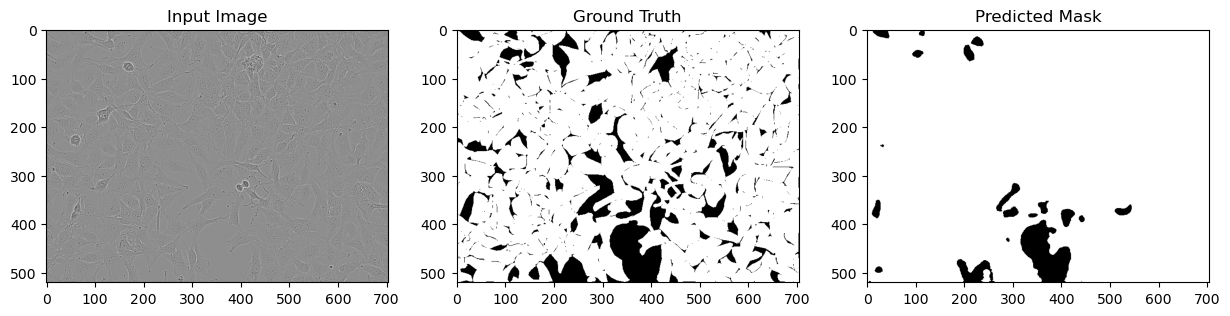

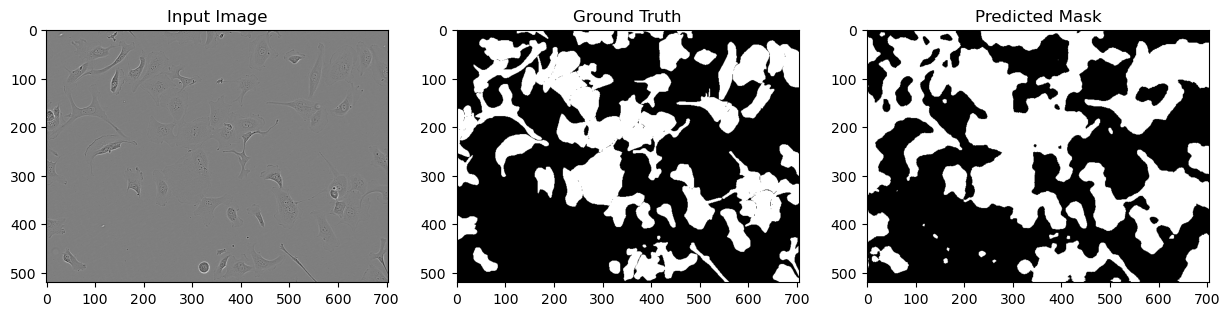

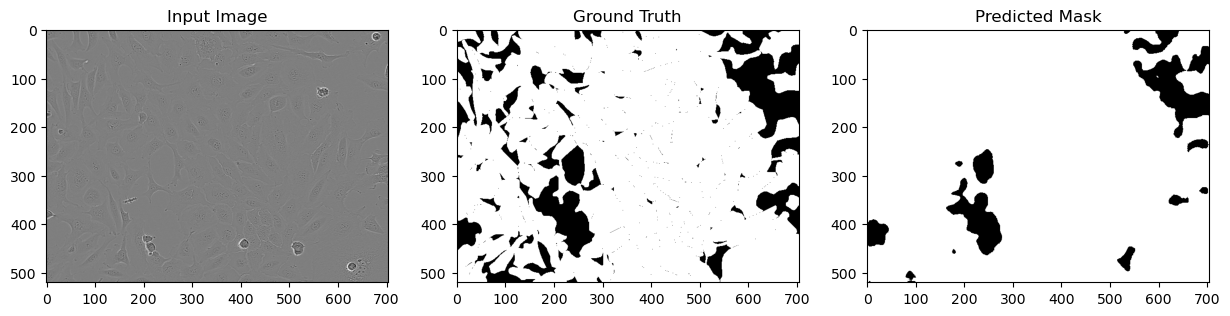

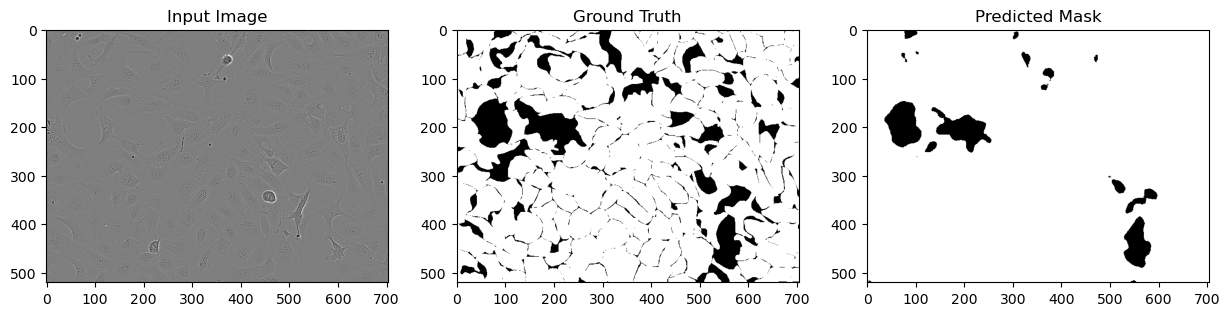

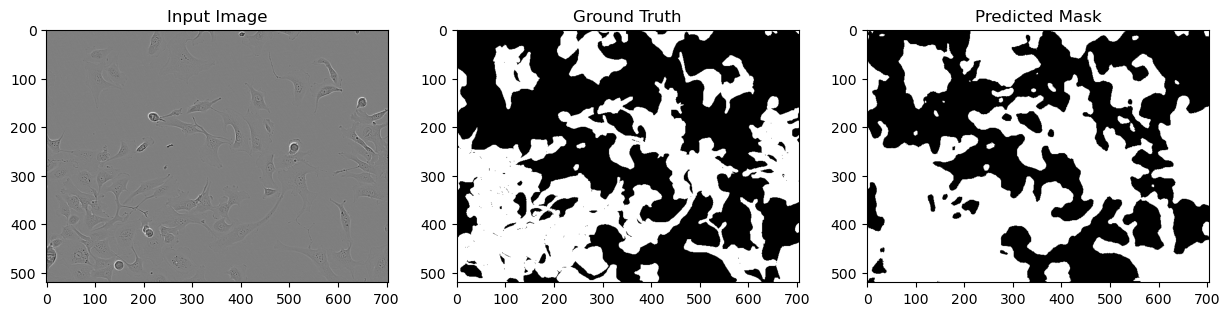

In [49]:
for test in test_subset:
    img, mask = test
    show_prediction(img, mask)

# Passive Learning Style Training

In [ ]:
def evaluate_model_on_subset(dataset, subset_indices, test_loader, epochs=5):
    subset = Subset(dataset, subset_indices)
    loader = DataLoader(subset, batch_size=4, shuffle=True)

    model = smp.Unet("resnet34", encoder_weights="imagenet", in_channels=1, classes=1, activation="sigmoid").to(device)
    loss_fn = smp.losses.DiceLoss(mode='binary')
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Training
    model.train()
    for _ in range(epochs):
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = loss_fn(preds, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    # Evaluation on training set after last epoch
    model.eval()
    train_dice_scores = []
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            preds_bin = (preds > 0.5).float()
            intersection = (preds_bin * masks).sum()
            union = preds_bin.sum() + masks.sum()
            dice = (2 * intersection) / (union + 1e-8)
            train_dice_scores.append(dice.item())
    final_train_dice = np.mean(train_dice_scores)
    
    # Evaluation on test set
    model.eval()
    test_dice_scores = []
    with torch.no_grad():
        for img, mask in test_loader:
            img, mask = img.to(device), mask.to(device)
            pred = model(img)
            pred_bin = (pred > 0.5).float()
            inter = (pred_bin * mask).sum()
            union = pred_bin.sum() + mask.sum()
            dice = (2 * inter) / (union + 1e-8)
            test_dice_scores.append(dice.item())
    return np.mean(train_dice_scores), np.mean(test_dice_scores)

In [20]:
initial_size = 100
increment = 100
max_size = int(0.5 * len(train_ds))
n_simulations = 3

In [21]:
all_indices = list(range(len(train_ds)))
dataset_sizes = list(range(initial_size, max_size + 1, increment))

In [ ]:
train_results, test_results = {}, {}
for sim in range(n_simulations):
    random.seed(sim)
    random.shuffle(all_indices)
    for size in dataset_sizes:
        current_subset = shuffled_indices[:size]  # always includes previous ones
        print(f"  Training on {size} samples...", end="")
        train_dice, test_dice = evaluate_model_on_subset(train_ds, current_subset, test_loader)
        print(f" Train Dice = {train_dice:.4f}")
        print(f" Test Dice = {test_dice:.4f}")
        train_results.setdefault(size, []).append(train_dice)
        test_results.setdefault(size, []).append(test_dice)

In [ ]:
means = [np.mean(train_results[s]) for s in dataset_sizes]
std_dev = [np.std(train_results[s] for s in dataset_sizes]

plt.errorbar(dataset_sizes, means, yerr=std_dev, fmt='-o', capsize=5)
plt.title("Passive Learning: Mean Training Dice Score vs Training Set Size")
plt.xlabel("Training Set Size")
plt.ylabel("Mean Test Set Dice Score")
plt.grid(True)
plt.show()

In [ ]:
means = [np.mean(test_results[s]) for s in dataset_sizes]
std_dev = [np.std(test_results[s] for s in dataset_sizes]

plt.errorbar(dataset_sizes, means, yerr=std_dev, fmt='-o', capsize=5)
plt.title("Passive Learning: Mean Test Set Dice Score vs Training Set Size")
plt.xlabel("Training Set Size")
plt.ylabel("Mean Test Set Dice Score")
plt.grid(True)
plt.show()